# A Sentiment Analysis of MLB Performance
### ADS-509 Final Project Team 11

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests

In [2]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
import re

The first step in our effort is to scrape blog post text from the mlbtraderumors.com website.  This posts include text, dates posted, and the authors name.  We will scrape this information and store it in a dataframe that we can use to start our text analysis.

In [3]:
# URL of the website to scrape
url = "https://www.mlbtraderumors.com/washington-nationals?show=all"

# Send a GET request to the website
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find all the news article elements
articles = soup.find_all("article")

# Create a file to save the scraped data
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_washington_nationals_articles1.txt" 
with open(file_path, "w", encoding="utf-8") as file:
    # Initialize empty lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []
    
    # Iterate over the articles and extract the text
    for article in articles:
        # Extract the article title
        title_element = article.find("h2")
        title = title_element.text.strip() if title_element else ""
        titles.append(title)

        # Extract the article author
        author_element = article.find("span", class_="entry-author")
        author = author_element.text.strip() if author_element else ""
        authors.append(author)

        # Extract the article date
        date_element = article.find("time", class_="entry-time")
        date = date_element.text.strip() if date_element else ""
        dates.append(date)

        # Extract the article content
        content_element = article.find("div", class_="entry-content")
        content = content_element.text.strip() if content_element else ""
        contents.append(content)
        
        # Write the title and content to the file
        file.write("Title: " + title + "\n")
        file.write("Author: " + author + "\n")
        file.write("Date: " + date + "\n")
        file.write("Content: " + content + "\n")
        file.write("---\n")

print("Data saved to", file_path)

# Create a DataFrame from the extracted values
data = {
    "Title": titles,
    "Author": authors,
    "Date": dates,
    "Content": contents
}

df = pd.DataFrame(data)
df.head()

Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/mlbtraderumors_washington_nationals_articles1.txt


,Title,Author,Date,Content
0,"Sean Doolittle Completes Rehab Assignment, Hea...",Steve Adams,"June 15, 2023",Veteran lefty Sean Doolittle was transferred f...
1,Nationals Release Erasmo Ramírez,Darragh McDonald,"June 9, 2023",The Nationals have released right-hander Erasm...
2,Best Deadline Rental Returns In Recent History...,Darragh McDonald,"June 8, 2023",With the trade deadline now less than two mont...
3,Nationals Claim Joe La Sorsa,Steve Adams,"June 8, 2023",The Nationals have claimed left-hander Joe La ...
4,Nationals Outright Andres Machado,Anthony Franco,"June 7, 2023",Nationals reliever Andrés Machado has gone unc...


In [4]:
#change the Date column to a datetime object:
df['Date'] = pd.to_datetime(df['Date'], format="%B %d, %Y", errors= 'coerce')

In [5]:
df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [6]:
# Check for missing values
df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [7]:
len(df)

1030

# Cleaning the Data

In [8]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [ ]:
df['Content'].apply

In [16]:
pd.options.display.max_colwidth = 100 ###
# add new column to data frame
df['impurity'] = df['Content'].apply(impurity, min_len=10)

# get the top 3 records
df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
601,The Nationals announced they’ve selected the contract of right-hander Steven Fuentes. The 23-yea...,0.003333
559,"Kyle Schwarber is now a member of the Washington Nationals, in no small part because of Nats man...",0.003155
565,The Nationals accomplished a big part of their winter to-do list when they acquired Josh Bell fr...,0.002786


The above shows the highest impurity levels for this data set.  Note, these are extremely low...well below 1% of all characters in each blog post are suspicious.

Now we'll do some character normalization with textacy

In [ ]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    # Place your Module 2 solution here
        # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
      # print the five most common tokens
        print("The five most common tokens are: ", Counter(tokens).most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [token for token in tokens if not token.lower() in sw]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))


RE_TOKEN = re.compile(r"""
               ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
               | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
               | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
               )
               """, re.VERBOSE)

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return RE_TOKEN.findall(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [17]:
#function to normalize text
import textacy
import textacy.preprocessing as tprep

if textacy.__version__ < '0.11':
    # as in book
    def normalize(text):
        text = tprep.normalize_hyphenated_words(text)
        text = tprep.normalize_quotation_marks(text)
        text = tprep.normalize_unicode(text)
        text = tprep.remove_accents(text)
        return text

else:
    # adjusted to textacy 0.11
    def normalize(text):
        text = tprep.normalize.hyphenated_words(text)
        text = tprep.normalize.quotation_marks(text)
        text = tprep.normalize.unicode(text)
        text = tprep.remove.accents(text)
        return text

In [19]:
df['Content'] = df['Content'].apply(normalize)

In [20]:
import nltk

df['tokens'] = nltk.tokenize.word_tokenize(df['Content'])
df.head()

TypeError: expected string or bytes-like object

Import data on the washington nationals from baseball-reference.com

https://www.baseball-reference.com/teams/WSN/attend.shtml

In [7]:


import pandas as pd

# URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/WSN/attend.shtml"

# Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

# Select the table of interest (index 0 in this case)
table = tables[0]

# Save the DataFrame as a CSV file
file_path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)




Data saved to C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/attendance_data.csv


In [8]:
path = "C:/Users/earne/OneDrive - University of San Diego/MSADS/ADS-509/Project/data/"

nats_df = pd.DataFrame(pd.read_csv(path + 'attendance_data.csv'))
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,25,36,5,NaN,709171.0,21490.0,11th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park


In [9]:
nats_df= nats_df[nats_df['Year'] > 2004]
nats_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,25,36,5,NaN,709171.0,21490.0,11th of 15,"$98,376,067",96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,"$125,051,666",96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,"$172,370,147",96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,"$172,237,283",99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,"$203,016,595",102,102,Nationals Park
5,2018,Washington Nationals,NL East,82,80,2,NaN,2529604.0,31230.0,8th of 15,"$188,886,699",105,106,Nationals Park
6,2017,Washington Nationals,NL East,97,65,1,Lost NLDS (3-2),2524980.0,31173.0,7th of 15,"$175,587,301",103,104,Nationals Park
7,2016,Washington Nationals,NL East,95,67,1,Lost NLDS (3-2),2481938.0,30641.0,7th of 15,"$152,967,400",102,103,Nationals Park
8,2015,Washington Nationals,NL East,83,79,2,NaN,2619843.0,32344.0,5th of 15,"$176,496,372",101,102,Nationals Park
9,2014,Washington Nationals,NL East,96,66,1,Lost NLDS (3-1),2579389.0,31844.0,7th of 15,"$137,235,080",102,104,Nationals Park


In [10]:
#remove the dollar sign from Est. Payroll column
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].replace({'\$':''}, regex = True)
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].replace({'\,':''}, regex = True)
nats_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Washington Nationals,NL East,25,36,5,NaN,709171.0,21490.0,11th of 15,98376067,96,94,Nationals Park
1,2022,Washington Nationals,NL East,55,107,5,NaN,2026401.0,25017.0,11th of 15,125051666,96,94,Nationals Park
2,2021,Washington Nationals,NL East,65,97,5,NaN,1465543.0,18093.0,12th of 15,172370147,96,95,Nationals Park
3,2020,Washington Nationals,NL East,26,34,5,NaN,NaN,NaN,15th of 15,172237283,99,99,Nationals Park
4,2019,Washington Nationals,NL East,93,69,2,Won WS (4-3),2259781.0,27899.0,11th of 15,203016595,102,102,Nationals Park


In [11]:
nats_df['Est. Payroll'] = nats_df['Est. Payroll'].astype(float)
nats_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

In [43]:
nats_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000
mean,2014.000000,73.315789,77.894737,3.368421,2.164161e+06,27462.111111,1.163850e+08,99.526316,99.263158
std,5.627314,21.587169,20.215216,1.738790,5.051465e+05,4574.987970,5.466072e+07,2.988281,3.983886
min,2005.000000,25.000000,34.000000,1.000000,7.091710e+05,18093.000000,3.694750e+07,95.000000,94.000000
25%,2009.500000,62.000000,66.500000,2.000000,1.941312e+06,24062.500000,6.604250e+07,96.000000,95.000000
50%,2014.000000,80.000000,80.000000,4.000000,2.290090e+06,28452.000000,1.124932e+08,100.000000,99.000000
75%,2018.500000,89.500000,92.000000,5.000000,2.528448e+06,31215.750000,1.723037e+08,101.500000,102.500000
max,2023.000000,98.000000,107.000000,5.000000,2.731993e+06,33728.000000,2.030166e+08,105.000000,106.000000


Text(0.5, 1.0, 'Attendance of Washington Nationals over the years')

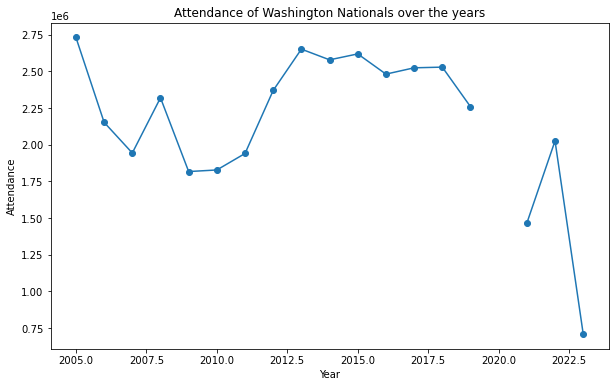

In [12]:
#plot data
# Plotting
plt.figure(figsize=(10, 6))

# Plotting Attendance over the years
plt.plot(nats_df['Year'], nats_df['Attendance'], marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Washington Nationals over the years')

Text(0.5, 1.0, 'Wins of Washington Nationals over the years')

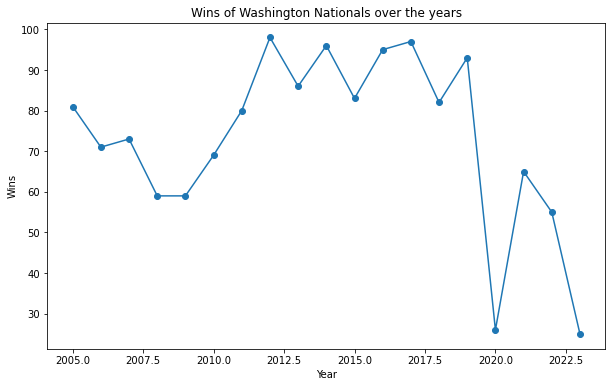

In [13]:
# Plotting Wins over the years
plt.figure(figsize=(10, 6))
plt.plot(nats_df['Year'], nats_df['W'], marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins of Washington Nationals over the years')

Text(0.5, 1.0, 'Payroll of Washington Nationals over the years')

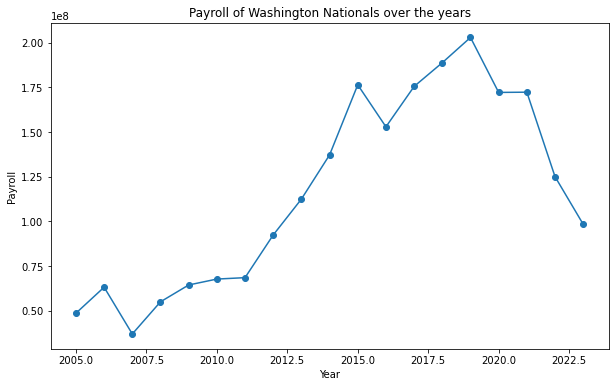

In [14]:
# Plotting Payroll over the years
plt.figure(figsize=(10, 6))
plt.plot(nats_df['Year'], nats_df['Est. Payroll'], marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Washington Nationals over the years')

                  Year         W         L    Finish  Attendance  Attend/G  \
Year          1.000000 -0.284460 -0.434648 -0.147622   -0.344338 -0.202696   
W            -0.284460  1.000000  0.168763 -0.793633    0.812749  0.661492   
L            -0.434648  0.168763  1.000000  0.322012    0.102852 -0.264288   
Finish       -0.147622 -0.793633  0.322012  1.000000   -0.584725 -0.631294   
Attendance   -0.344338  0.812749  0.102852 -0.584725    1.000000  0.891240   
Attend/G     -0.202696  0.661492 -0.264288 -0.631294    0.891240  1.000000   
Est. Payroll  0.772917  0.173634 -0.374900 -0.491810    0.209334  0.232487   
PPF           0.148668  0.520898 -0.180205 -0.734371    0.508759  0.505249   
BPF           0.153642  0.605563 -0.261083 -0.832812    0.596436  0.601454   

              Est. Payroll       PPF       BPF  
Year              0.772917  0.148668  0.153642  
W                 0.173634  0.520898  0.605563  
L                -0.374900 -0.180205 -0.261083  
Finish           -0.491

Text(0.5, 1.0, 'Correlation Matrix')

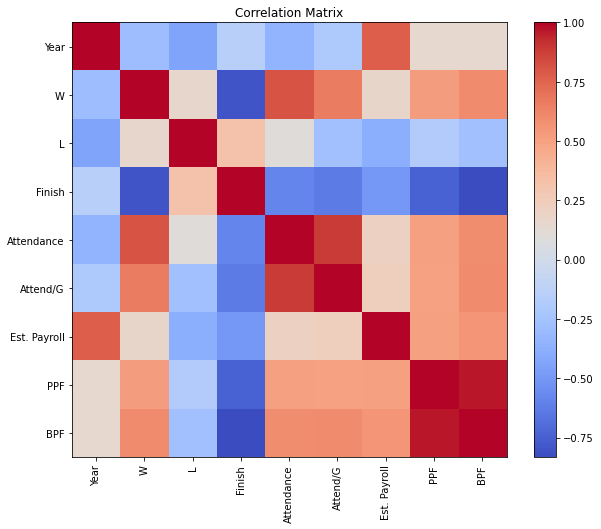

In [15]:
# Correlation matrix
correlation = nats_df.corr()
print(correlation)

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
plt.yticks(range(len(correlation)), correlation.columns)
plt.title('Correlation Matrix')